# Exam project

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Group name: 2x Chris & Ras

In [688]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
from scipy.optimize import minimize
import pandas as pd

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

First, we write up all the parameters needed for solving the problem, and write up any functions and constraints related to the maximisation problem. We then take the First Order Condition (FOC) w.r.t. the hours of labor, $L$. We rewrite the FOC, such that we set up a second degree polynomial.

In [689]:
# Define the symbols
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
v = sm.symbols('v')
w = sm.symbols('w')
tau = sm.symbols('tau')
L = sm.symbols('L')
G = sm.symbols('G')
C = sm.symbols('C')
w_tilde = sm.symbols('w_tilde')

# Define the utility function
utility = sm.log(C**alpha * G**(1-alpha)) - v*(L**2)/2

# Define the constraint
constraint = sm.Eq(C, kappa + w_tilde*L)

# Substitute the constraint into the utility function
complete = utility.subs(C, constraint.rhs)

# Differentiate the complete function w.r.t L
dU_dL = sm.diff(complete, L)
FOC = sm.Eq(0, dU_dL)

# Add L*v to both sides of FOC and then make the equation not divided in anything to read the polynomial formula
FOC_updated = sm.Eq(FOC.lhs + L*v, FOC.rhs + L*v)
FOC_updated = sm.Eq(FOC_updated.lhs * (L*w_tilde + kappa), FOC_updated.rhs * (L*w_tilde + kappa))
FOC_updated = sm.Eq(FOC_updated.lhs, FOC_updated.rhs - G**(1-alpha)*G**(alpha-1)*alpha*w_tilde + alpha * w_tilde)
FOC_updated = sm.Eq(FOC_updated.lhs - alpha * w_tilde, FOC_updated.rhs - alpha * w_tilde)

# Display the updated FOC equation
FOC_updated

Eq(L*v*(L*w_tilde + kappa) - alpha*w_tilde, 0)

We can from the above result see that it gives the following polynomial equation:

$L^2 \cdot \tilde{w} + L \cdot \kappa - \frac{\alpha}{v} \cdot \tilde{w} = 0$

We can therefore use the discriminant formula, which is:

$d = b^2 - 4\cdot a \cdot c$

We can read those from the above result and then find the solution down below.

In [690]:
# The following is read from the polynomial equation
a = w_tilde
b = kappa
c = alpha/v * w_tilde
d = b**2 - 4*a*c

L = (-b + sm.sqrt(d))/(2*a)
L

(-kappa + sqrt(-4*alpha*w_tilde**2/v + kappa**2))/(2*w_tilde)

By finding the roots of this second degree polynomial, we find the exact result. 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In this question we will take the $L^{\star}(\tilde{w})$ that we found from the question above and insert the $\tilde{w} = (1-\tau)w$. We then plot the graph to see how the optimal labor supply depends on wage:

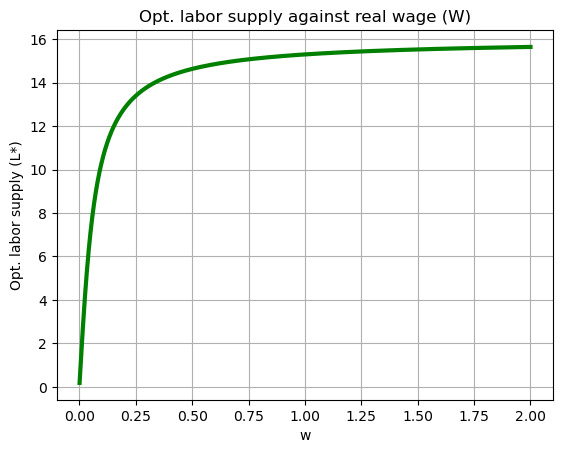

In [691]:
# We insert the parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
tau = 0.30

w_val = np.linspace(0.001, 2.0, 1000)  # Range of w values to plot
tilde_w_val = (1 - tau) * w_val    # make w_tilde

# We insert the opt. labor supply function
opt_labor = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * tilde_w_val**2)) / (2 * tilde_w_val)

# We then plot the opt. labor supply function with the real wage values which is between 0 to 2
plt.plot(w_val, opt_labor, color='green', linewidth=3)
plt.xlabel('w')
plt.ylabel('Opt. labor supply (L*)')
plt.title('Opt. labor supply against real wage (W)')
plt.grid(True)
plt.show()

We can see that it is a logarithmic function where it goes towards 16 in optimal labor supply when w goes towards unlimited.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We begin by defining the parameters once more, and constructing a grid of 100 different values of $\tau$ in the interval $\{0.001,0.999\}$. We then loop the calculated labor hours, $L$, worker utility, $V$, and government consumption, $G$ for each value of $\tau$.

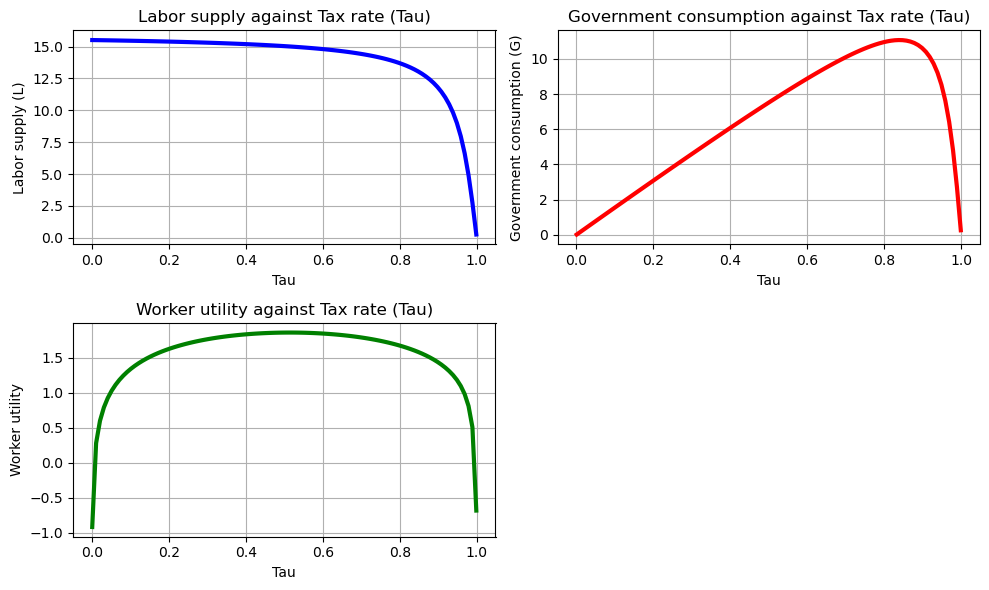

In [692]:
# Inserting the parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

# Creates the values that tau needs to be run through
tau_v = np.linspace(0.001, 0.999, 100)  

# Make the empty arrays, so we can store the values for the plot inside these
lab_s = []
gov_c = []
work_u = []

# For loop where we go through all the tau values
for tau in tau_v:
    tilde_w = (1 - tau) * w

    # Finding the optimal labor value for the different tau values
    opt_labor = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * tilde_w**2)) / (2 * tilde_w)
    
    # Calculating the government spending by the above optimal labor
    govern_spend = tau * w * opt_labor

    # Calculating the worker utility by the given parameter values and by the calculated government spending and labor supply
    utility = np.log((kappa + (1 - tau) * w * opt_labor)**alpha * govern_spend**(1 - alpha)) - (nu * opt_labor**2) / 2
    
    # Appending in the calculated labor value into the array lab_s
    lab_s.append(opt_labor)
    
    # Appending in the calculated government spending into the array gov_c
    gov_c.append(govern_spend)

    # Appending in the calculated worker utility into the array work_u
    work_u.append(utility)

# Plotting
plt.figure(figsize=(10, 6))

# Labor Supply plot
plt.subplot(2, 2, 1)
plt.plot(tau_v, lab_s, color='blue', linewidth=3)
plt.xlabel('Tau')
plt.ylabel('Labor supply (L)')
plt.title('Labor supply against Tax rate (Tau)')
plt.grid(True)

# Government Consumption plot
plt.subplot(2, 2, 2)
plt.plot(tau_v, gov_c, color='red', linewidth=3)
plt.xlabel('Tau')
plt.ylabel('Government consumption (G)')
plt.title('Government consumption against Tax rate (Tau)')
plt.grid(True)

# Worker Utility plot
plt.subplot(2, 2, 3)
plt.plot(tau_v, work_u, color='green', linewidth=3)
plt.xlabel('Tau')
plt.ylabel('Worker utility')
plt.title('Worker utility against Tax rate (Tau)')
plt.grid(True)

plt.tight_layout()
plt.show()

We see from the three graphs, that our analysis seems to be in accordance to our theoretical expectations. The incentive for labor hours diminish faster when taxation becomes sufficiently higher. The government consumption seem to increase until at certain point of taxation, where the low labor hours of the workers will be too diminished for the government to receive any taxation revenue. The worker utility seems to favour a more balanced taxation, which makes sense, when you consider that the worker has an equal preference of private and governmental consumption ($\alpha = 0.5$).

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

We construct the worker utility as a function of $\tau$ in the same way as in problem 1.3, but now with 1000 values of $\tau$ instead of 100. We then find the value of $\tau$ that maximises worker utility, which we interpret as the social optimal.

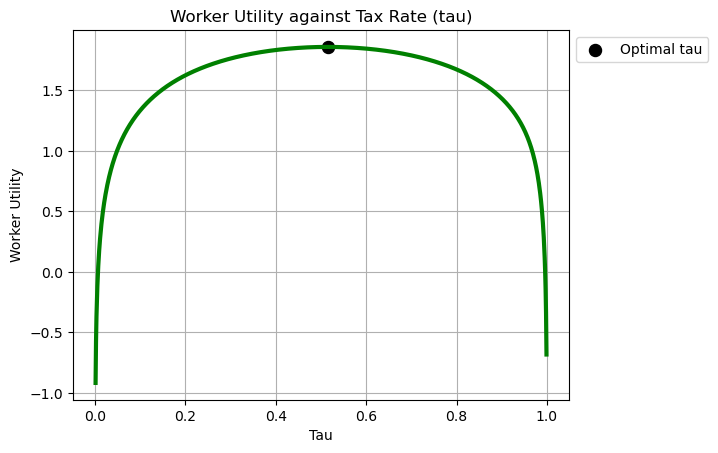

Optimal tax rate (tau): 0.51
Maximized worker utility: 1.86


In [693]:
# Setting the parameters values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

# Setting the values for tau
tau_v = np.linspace(0.001, 0.999, 1000)  

# Making an empty array, where we can store the for loop values in
worker_u = []

# finding the worker utility when running through the different tau_v between 0 and 1
for tau in tau_v:
    tilde_w = (1 - tau) * w
    
    # Finding the optimal value for labor supply
    opt_l = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * tilde_w**2)) / (2 * tilde_w)
    
    # Finding the optimal government spending when we have found the optimal labor supply
    govern_spend = tau * w * opt_l

    # When found the optimal labor and government spending it can be plugged into the utility function and hereby find the worker utility
    utility = np.log((kappa + (1 - tau) * w * opt_l)**alpha * govern_spend**(1 - alpha)) - (nu * opt_l**2) / 2

    # Appending the above calculated utility into the list
    worker_u.append(utility)

# Finding the socially optimal tax rate
optimal_tau_index = np.argmax(worker_u)
optimal_tau = tau_v[optimal_tau_index]
optimal_utility = worker_u[optimal_tau_index]

# Plotting the worker utility against tax rate, tau.
plt.plot(tau_v, worker_u, color='green', linewidth=3)
plt.scatter(optimal_tau, optimal_utility, color='black', label='Optimal tau', s=75)
plt.xlabel('Tau')
plt.ylabel('Worker Utility')
plt.title('Worker Utility against Tax Rate (tau)')
plt.legend(bbox_to_anchor = (1 , 1))
plt.grid(True)
plt.show()

# Printing the optimal tax rate and max. worker utility
print("Optimal tax rate (tau): {:.2f}".format(optimal_tau))
print("Maximized worker utility: {:.2f}".format(optimal_utility))

We then find that the optimal tax rate is $0.51$ and that gives the worker utility of $1.86$

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

We have to find the $G$ that solves the given equation. To do this we maximise to find the $L^*$ value and then we find a general solution for G. Next we insert the values for set 1 and set 2.


In [694]:
import scipy.optimize as opt

def labor_sup(w, tau, G, sigma, rho, epsilon):
    # Defining the general preference formulation for the worker with the secondary condition
    def objec(L, w, tau, G, sigma, rho, epsilon):
        C = kappa + (1 - tau) * w * L
        value = (((alpha * C**((sigma-1)/sigma) + (1 - alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho) - 1)/(1-rho) - nu * (L**(1+epsilon))/(1+epsilon)
        return -value  # Negative value for maximization
    
    # Maximizing to find the L star value, where the negative value of the objec function is taken and minimizing, which gives maximization
    L_star = opt.minimize_scalar(objec, bounds=(0, 24), args=(w, tau, G, sigma, rho, epsilon), method='bounded').x
    return L_star

# Using the function that is given for G that needs to be used
def find_G(tau, sigma, rho, epsilon):
    def equa(G, w, tau, sigma, rho, epsilon):
        return G - tau * w * labor_sup(w, tau, G, sigma, rho, epsilon)
    
    result = opt.root_scalar(equa, args=(w, tau, sigma, rho, epsilon), method='brentq', bracket=(0, 1000))
    G_sol = result.root
    return G_sol

# Setting the relevant parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0
tau = optimal_tau

# Given parameter values for set 1
sigma_s1 = 1.001
rho_s1 = 1.001
epsilon_s1 = 1.0

# Given parameter values for set 2
sigma_s2 = 1.5
rho_s2 = 1.5
epsilon_s2 = 1.0

# Calculate G for Set 1 and printing it after
G_solution_set1 = find_G(tau, sigma_s1, rho_s1, epsilon_s1)
print("Set 1: G =", G_solution_set1)

# Calculate G for Set 2 and printing it after
G_solution_set2 = find_G(tau, sigma_s2, rho_s2, epsilon_s2)
print("Set 2: G =", G_solution_set2)

Set 1: G = 7.710581392679844
Set 2: G = 4.974885272151633


The results we get for set 1 is that the government consumption $G$ should be equal to 7.71. The result for the government consumption with set 2 is 4.97.

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

To find the socially optimal $\tau^*$ we find $L^*$ in the equation for government consumption and then we solve for $\tau$. 

In [695]:
import scipy.optimize as opt

def labor_sup(w, tau, G, sigma, rho, epsilon):
    # Defining the general preference formulation for the worker with the secondary condition
    def objec(L, w, tau, G, sigma, rho, epsilon):
        C = kappa + (1 - tau) * w * L
        value = (((alpha * C**((sigma-1)/sigma) + (1 - alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho) - 1)/(1-rho) - nu * (L**(1+epsilon))/(1+epsilon)
        return -value  # Negative value for maximization
    
    # Maximizing to find the L star value, where the negative value of the objec function is taken and minimizing, which gives maximization
    L_star = opt.minimize_scalar(objec, bounds=(0, 24), args=(w, tau, G, sigma, rho, epsilon), method='bounded').x
    return L_star

# Function for finding tau star, which is done through finding the L star, because of the given equation for government spending
def tau_star(G, sigma, rho, epsilon):
    # The government spending equation
    def equa(tau, w, G, sigma, rho, epsilon):
        L_star = labor_sup(w, tau, G, sigma, rho, epsilon)
        return G - tau * w * L_star
    
    # A valid bracket for tau is between 0 and 1 because the tax rate cannot be lower than 0% and higher than 100%
    a = 0.0
    b = 1.0

    # This helps with finding the root within the bracket. The bracket will be expanded if the signs are the same
    while np.sign(equa(a, w, G, sigma, rho, epsilon)) == np.sign(equa(b, w, G, sigma, rho, epsilon)):
        b *= 2.0
    
    # We now solve for tau within the above bracket, which is between 0 and 1 or 0% and 100%
    result = opt.root_scalar(equa, args=(w, G, sigma, rho, epsilon), method='brentq', bracket=(a, b))
    tau_star = result.root
    return tau_star

# We insert the given parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

# Parameter set 1
sigma_set1 = 1.001
rho_set1 = 1.001
epsilon_set1 = 1.0

# Parameter set 2
sigma_set2 = 1.5
rho_set2 = 1.5
epsilon_set2 = 1.0

# We find here the social optimal tax rate for the parameter set 1 and after print it
tau_star_set1 = tau_star(G_solution_set1, sigma_set1, rho_set1, epsilon_set1)
print("Set 1: Socially optimal tax rate (tau*):", tau_star_set1)

# We find here the social optimal tax rate for the parameter set 2 and after print it
tau_star_set2 = tau_star(G_solution_set2, sigma_set2, rho_set2, epsilon_set2)
print("Set 2: Socially optimal tax rate (tau*):", tau_star_set2)

Set 1: Socially optimal tax rate (tau*): 0.5144854372415884
Set 2: Socially optimal tax rate (tau*): 0.5144854854859953


/var/folders/1t/g6pbwy2d0xs212cq6dztdzn80000gn/T/ipykernel_39031/2375700040.py:7: RuntimeWarning: invalid value encountered in double_scalars
  value = (((alpha * C**((sigma-1)/sigma) + (1 - alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho) - 1)/(1-rho) - nu * (L**(1+epsilon))/(1+epsilon)


For the first set of parameters we get a socially optimal tax rate to be 0.514485437 and for the second set of parameters we get the socially optimal tax rate to be 0.5144854854. The two tax rates are almost alike also with the optimal tax rate found in problem 1.4. This is because the optimal tax rate is quite inelastic because both private and government consumption benefit the worker.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We verify that the given equation of $l_t$ maximises profit by maximising the profit function wrt. $l_t$ within Python given a certain value of $\kappa$ and comparing it to value of the given $l_t$ equation for the same given $\kappa$. We do this across a list of different $\kappa$ values, to check that it only holds for $\kappa \in \{1.0,2.0\}$.

In [696]:
from scipy.optimize import minimize

# Constants and parameters
eta = 0.5
w = 1.0

# Define the profit function
def profit_func(x):
    ll_t, kappa = x
    return kappa * ll_t ** (1 - eta) - w * ll_t

# Define the negative of the profit function (to maximize instead of minimize)
def neg_profit_func(x):
    return -profit_func(x)

# Define the kappa values for the table
kappa_values = [0.5, 1.1, 1.5, 2, 2.5]

# Create an empty list to store the data
data = []

# Perform the optimization and populate the data list
for kappa in kappa_values:
    bounds = [(0, None), (kappa, kappa)]
    result = minimize(neg_profit_func, x0=(1, kappa), bounds=bounds)
    optimal_ll_t, optimal_kappa = result.x
    optimal_profit = -result.fun
    l_t = ((1 - eta) * optimal_kappa / w) ** (1 / eta)
    data.append({'Kappa': kappa, 'Optimal l_t': optimal_ll_t, 'Optimal profit': optimal_profit, 'L_t value for function': l_t})

# Create the table as a DataFrame
df = pd.DataFrame(data)
df = df.set_index('Kappa')
pd.options.display.float_format = '{:.6f}'.format

# Print the table
print(df)

          Optimal l_t  Optimal profit  L_t value for function
Kappa                                                        
0.500000     0.062501        0.062500                0.062500
1.100000     0.302500        0.302500                0.302500
1.500000     0.562500        0.562500                0.562500
2.000000     1.000000        1.000000                1.000000
2.500000     1.562496        1.562500                1.562500


As we see, the values of $l_t$ are the same whether we optimise or insert in the equation when $\kappa \in \{1.0,2.0\}$, and are not the same outside of the interval.

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

To calculate H, we define the initial shock series and make a loop, which represents the 120 months. To make sure our approximation is as close to the actual true value as possible, we choose the number of simulated shock series to be 1000. Our labor hours are given by the equation in problem 2.1.

In [697]:
# Setting the relevant parameter values
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
K = 1000  # Number of shock series to simulate

np.random.seed(0)  # Set random seed for reproducibility

# Function to calculate salon value for a given shock series (sho_ser)
def cal_salon_val(sho_ser):
    kappa_t_prev = 1.0  # Initial demand shock
    lt_prev = 0.0  # Initial number of employees
    salon_val = 0.0  # Initial salon value

    # Making a for loop for the range of 0 to 120, which represents the 120 months or 10 years
    for t in range(120):
        # The AR(1) demand shock equation
        kappa_t = np.exp(rho * np.log(kappa_t_prev) + sho_ser[t])

        # The policy equation
        lt = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # The profit function
        profit = kappa_t * lt ** (1 - eta) - w * lt - (lt != lt_prev) * iota
        discounted_profit = profit * R ** (-t)
        salon_val += discounted_profit

        kappa_t_prev = kappa_t  # Update for the next period
        lt_prev = lt  # Update for the next period

    return salon_val

salon_val = np.zeros(K)

for k in range(K):
    sho_ser = np.random.normal(-0.5 * sigma_epsilon ** 2, sigma_epsilon, size=120)
    salon_val[k] = cal_salon_val(sho_ser)

H = np.mean(salon_val)
print("H with K equal", K, "=", H)

H with K equal 1000 = 27.81957901976801


Thus, we get that $H$ for this specific policy is given at 27.82, approximately.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

To calculate $H$ we set the parameter values and simulate the model with 1000 shock series. Then we generate the demand shocks, calculate the employment level and the profit. Then we calculate $H$ as the average of the objective function values. 

In [698]:
# Setting the relevant parameter values
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
K = 1000  # Number of shock series to simulate
delta = 0.05  # Policy parameter delta

np.random.seed(0)  # Set random seed for reproducibility

# Function to calculate salon value for a given shock series (sho_ser)
def cal_salon_val(sho_ser):
    kappa_t_prev = 1.0  # Initial demand shock
    lt_prev = 0.0  # Initial number of employees
    salon_val = 0.0  # Initial salon value

    # Making a for loop for the range of 0 to 120, which represents the 120 months or 10 years
    for t in range(120):
        # The AR(1) demand shock equation
        kappa_t = np.exp(rho * np.log(kappa_t_prev) + sho_ser[t])

        # The policy equation
        lt_ast = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # Check if the employment level should be adjusted
        if abs(lt_prev - lt_ast) > delta:
            lt = lt_ast
        else:
            lt = lt_prev

        # The profit function
        profit = kappa_t * lt ** (1 - eta) - w * lt - (lt != lt_prev) * iota
        discounted_profit = profit * R ** (-t)
        salon_val += discounted_profit

        kappa_t_prev = kappa_t  # Update for the next period
        lt_prev = lt  # Update for the next period

    return salon_val

salon_val = np.zeros(K)

for k in range(K):
    sho_ser = np.random.normal(-0.5 * sigma_epsilon ** 2, sigma_epsilon, size=120)
    salon_val[k] = cal_salon_val(sho_ser)

H = np.mean(salon_val)
print("H with policy Delta =", delta, ":", H)

H with policy Delta = 0.05 : 28.49912709563243


We calculated $H$ to be 28.50, which means that with a policy of 0.05 it will improve the profitability of the salon with 28.50. 

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In this problem, we estimate the previous policy, that maximises the $H$ (which is the same as maximising profits). We do this by looping through the possible values of $\Delta$, and maximise $H$ given the possible demand shocks and time.


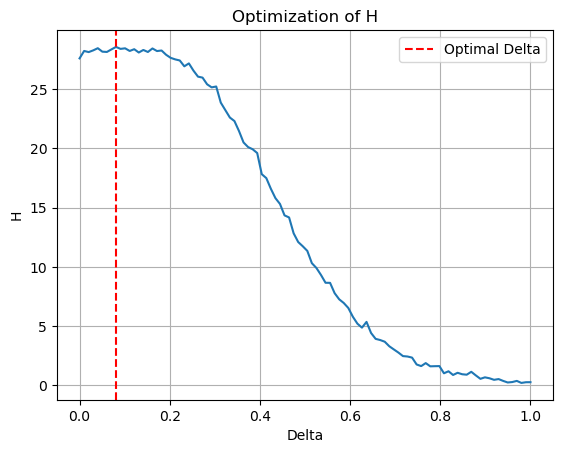

Optimal Delta: 0.081
Maximized H: 28.73


In [699]:
# Set the parameter values
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
K = 1000  # Number of shock series to simulate

# Function to calculate salon value for a given shock series (sho_ser) and delta
def cal_salon_val(sho_ser, delta):
    kappa_t_prev = 1.0  # Initial demand shock
    lt_prev = 0.0  # Initial number of employees
    salon_val = 0.0  # Initial salon value

    # Making a for loop for the range of 0 to 120, which represents the 120 months or 10 years
    for t in range(120):
        # The AR(1) demand shock equation
        kappa_t = np.exp(rho * np.log(kappa_t_prev) + sho_ser[t])

        # The policy equation
        lt_ast = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # Check if the employment level should be adjusted
        if abs(lt_prev - lt_ast) > delta:
            lt = lt_ast
        else:
            lt = lt_prev

        # The profit function
        profit = kappa_t * lt ** (1 - eta) - w * lt - (lt != lt_prev) * iota
        discounted_profit = profit * R ** (-t)
        salon_val += discounted_profit

        kappa_t_prev = kappa_t  # Update for the next period
        lt_prev = lt  # Update for the next period

    return salon_val

# Define the range of Delta values to consider
delta_val = np.linspace(0.0, 1.0, 100)

np.random.seed(0)  # Set random seed for reproducibility

# Initialize the list to store the results
results = []

# Define the objective function to maximize
def objective(delta):
    salon_val = np.zeros(K)
    
    for k in range(K):
        sho_ser = np.random.normal(-0.5 * sigma_epsilon ** 2, sigma_epsilon, size=120)
        salon_val[k] = cal_salon_val(sho_ser, delta)
    
    H = np.mean(salon_val)
    return -H  # Negate H for maximization

# Find the optimal Delta that maximizes H
opt_result = opt.minimize_scalar(objective, bounds=(0, 0.2), method='bounded')

# Extract the optimal delta and the corresponding maximized H
opt_delta = opt_result.x
max_H = -opt_result.fun

# Calculate the results for all delta values
for delta in delta_val:
    result = -objective(delta)
    results.append(result)

# Plot the results
plt.plot(delta_val, results, linestyle='solid')
plt.xlabel('Delta')
plt.ylabel('H')
plt.title('Optimization of H')
plt.axvline(x=opt_delta, color='r', linestyle='--', label='Optimal Delta')
plt.legend()
plt.grid(True)
plt.show()

print("Optimal Delta: {:.3f}".format(opt_delta))
print("Maximized H: {:.2f}".format(max_H))

The optimal previous policy, $\Delta$, to optimise $H$ is 0.081, which gives us an H 28.73, which is the optimal profitability of the saloon. 


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



We could imagine, that by taking a greater amount of previous observations of $l_t$ into account and clearing these values by finding the mean value, the salon would have a clearer view of the deviation from the optimal amount of $l_t$, which could lead to higher profits. In other words, when we have more information, the decision-making becomes better, and the profits could rise. We therefore will take into account the last 3 periods of policy and therefore change the following equations to this:


$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\mathbb{E}[\ell_{t-3}+\ell_{t-2}+\ell_{t-1}]}\iota\right]\right]
$$

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\mathbb{E}[\ell_{t-3}+\ell_{t-2}+\ell_{t-1}]-\ell_t^{\ast} \right|>\Delta\\
\mathbb{E}[\ell_{t-3}+\ell_{t-2}+\ell_{t-1}] & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$

In [700]:
# Setting the relevant parameter values
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
K = 1000  # Number of shock series to simulate
delta = 0.05  # Policy parameter delta

np.random.seed(0)  # Set random seed for reproducibility

# Function to calculate salon value for a given shock series (sho_ser)
def cal_salon_val(sho_ser):
    kappa_t_prev = 1.0  # Initial demand shock
    lt_prev_t_minus_1 = 0.0  # Initial number of employees for 1 period ago
    lt_prev_t_minus_2 = 0.0  # Initial number of employees for 2 periods ago
    lt_prev_t_minus_3 = 0.0  # Initial number of employees for 3 periods ago
    salon_val = 0.0  # Initial salon value

    # Making a for loop for the range of 0 to 120, which represents the 120 months or 10 years
    for t in range(120):
        # The AR(1) demand shock equation
        kappa_t = np.exp(rho * np.log(kappa_t_prev) + sho_ser[t])

        # The policy equation
        lt_ast = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # Check if the employment level should be adjusted
        if abs(np.mean(lt_prev_t_minus_1+lt_prev_t_minus_2+lt_prev_t_minus_3) - lt_ast) > delta:
            lt = lt_ast
        else:
            lt = np.mean(lt_prev_t_minus_1+lt_prev_t_minus_2+lt_prev_t_minus_3)

        # The profit function
        profit = kappa_t * lt ** (1 - eta) - w * lt - (lt != np.mean(lt_prev_t_minus_1+lt_prev_t_minus_2+lt_prev_t_minus_3)) * iota
        discounted_profit = profit * R ** (-t)
        salon_val += discounted_profit

        kappa_t_prev = kappa_t  # Update for the next period
        lt_prev_t_minus_3 = lt_prev_t_minus_2  # Update for the next period
        lt_prev_t_minus_2 = lt_prev_t_minus_1  # Update for the next period
        lt_prev_t_minus_1 = lt  # Update for the next period


    return salon_val

salon_val = np.zeros(K)

for k in range(K):
    sho_ser = np.random.normal(-0.5 * sigma_epsilon ** 2, sigma_epsilon, size=120)
    salon_val[k] = cal_salon_val(sho_ser)

H = np.mean(salon_val)
print("H with policy Delta =", delta, ":", H)

H with policy Delta = 0.05 : 27.825907521900508


We actually get a result which is lower compared to the result from question 2.3. This is not what we have expecteced, but we still see this as a more precise and correct result to estimate the profit of the salon.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [701]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

We setup the above griewank process for finding the global optimum. 

In [718]:
def refined_global_optimizer(bounds, tolerance, lower_K, upper_K):
    x_best = None
    f_best = np.inf

    for k in range(upper_K):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)

        if k >= lower_K:
            chi_k = 0.5 * (2 / (1 + np.exp((k - lower_K) / 100)))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_best
            x0 = x_k0
        else:
            x0 = x_k

        result = minimize(griewank, x0, method='BFGS', tol=tolerance)
        x_k_ast = result.x
        f_k_ast = result.fun

        if k == 0 or f_k_ast < f_best:
            x_best = x_k_ast
            f_best = f_k_ast

        if f_best < tolerance:
            break

    return x_best

np.random.seed(0)  # Set random seed for reproducibility

# Settings
bounds = [-600, 600]
tolerance = 1e-8
lower_K = 10
upper_K = 1000

# Run the optimizer
x_ast = refined_global_optimizer(bounds, tolerance, lower_K, upper_K)

print("Optimization Result:")
print(f"x_ast = {x_ast}, f(x_ast) = {griewank(x_ast)}")


Optimization Result:
x_ast = [-8.48060098e-09  5.55288883e-10], f(x_ast) = 0.0


The value we get with a $k$-value on 10 is close to the optimal Griewank result is $(0,0)$.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

We now take the code from question 3.1 and implement the K value for 100 instead of 10, and see what the difference is:

In [719]:
def refined_global_optimizer(bounds, tolerance, lower_K, upper_K):
    x_best = None
    f_best = np.inf

    for k in range(upper_K):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)

        if k >= lower_K:
            chi_k = 0.5 * (2 / (1 + np.exp((k - lower_K) / 100)))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_best
            x0 = x_k0
        else:
            x0 = x_k

        result = minimize(griewank, x0, method='BFGS', tol=tolerance)
        x_k_ast = result.x
        f_k_ast = result.fun

        if k == 0 or f_k_ast < f_best:
            x_best = x_k_ast
            f_best = f_k_ast

        if f_best < tolerance:
            break

    return x_best

np.random.seed(0)  # Set random seed for reproducibility

# Settings
bounds = [-600, 600]
tolerance = 1e-8

# Run the optimizer with lower_K = 10
lower_K_10 = 10
upper_K = 1000
x_ast_lower_K_10 = refined_global_optimizer(bounds, tolerance, lower_K_10, upper_K)

# Run the optimizer with lower_K = 100
lower_K_100 = 100
x_ast_lower_K_100 = refined_global_optimizer(bounds, tolerance, lower_K_100, upper_K)

print("Optimization Result (lower_K = 10):")
print(f"x_ast = {x_ast}, f(x_ast) = {griewank(x_ast)}")

print("Optimization Result (lower_K = 100):")
print(f"x_ast = {x_ast_lower_K_100}, f(x_ast) = {griewank(x_ast_lower_K_100)}")

Optimization Result (lower_K = 10):
x_ast = [-8.48060098e-09  5.55288883e-10], f(x_ast) = 0.0
Optimization Result (lower_K = 100):
x_ast = [-8.97861058e-09  1.58991965e-09], f(x_ast) = 0.0


Both results comes very close to (0,0), which is shown as the x_ast. We can see that the optimization with K=100 gives a closer result to (0,0). It still shows that by changing the K from 10 to 100 does not make a significant effect. Both the function value is (0,0) in the optimizations. 